# Table of Contents
* [Setup](#Setup)
	* [estimate cost](#estimate-cost)
	* [load dataset](#load-dataset)
* [Submitting HITs](#Submitting-HITs)
* [Retrieve results](#Retrieve-results)
* [Interact with workers](#Interact-with-workers)
* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)


In [15]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math 
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2


import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)


import re
import pickle
import boto
from copy import deepcopy
import json
import os
import jinja2
import random
from tqdm import tqdm

from IPython.core.display import HTML

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo


from amt_utils.mturk import MTurk
from amt_utils.mturk import pickle_this, unpickle_this

# Setup - Stage 4

In [38]:
dataset = unpickle_this('./pickled_data/flinstones_v0p3_sample_100.pkl')

In [87]:
dataset = unpickle_this('obj_data.pkl')

In [17]:
single_sent_vids = unpickle_this('./pickled_data/single_sent_vids.pkl')
two_sent_vids = unpickle_this('./pickled_data/two_sent_vids.pkl')
three_sent_vids = unpickle_this('./pickled_data/three_sent_vids.pkl')

In [18]:
current_batch = {vid.gid(): vid.description() for vid in three_sent_vids}

In [19]:
from amt_utils.flintstones import prepare_stage_4a_hit
from amt_utils.flintstones import prepare_stage_4b_hit
from amt_utils.flintstones import write_task_page
from amt_utils.flintstones import generate_simpler_task_page

from amt_utils.mturk import expected_cost

In [396]:
turk_account = mturk_ai2
rw_host='mechanicalturk.amazonaws.com'
amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key, host=rw_host)
# amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key)
amt_con.get_account_balance()

$652.80

In [39]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

In [343]:
s4a_go_vids = unpickle_this('../../build_dataset/s4a_rem_batch_2.pkl')

In [344]:
len(s4a_go_vids)

3042

In [250]:
vids_with_parts_ids = unpickle_this('ids_to_target.pkl')

In [253]:
videos_w_parts = [vid for vid in videos_w_objs if vid.gid() in vids_with_parts_ids]
videos_wo_parts = [vid for vid in videos_w_objs if vid.gid() not in vids_with_parts_ids]

In [296]:
vids_test_new_inst = videos_w_parts[60:] + videos_wo_parts[40:]

In [297]:
len(vids_test_new_inst)

4406

In [319]:
(len(videos_wo_parts))

4124

In [398]:
s3b_additional_go_vids = unpickle_this('../../build_dataset/additional_3b_batch_1.pkl')

In [399]:
current_batch = {vid.gid(): vid.description() for vid in s3b_additional_go_vids}

In [400]:
len(current_batch)

1809

# Submitting HITs- task a

In [406]:
static_params = {
    'title': "Mark objects mentioned in sentences",
    'description': "You will be presented with 1-3 sentences describing a scene. The task is to mark words in these sentences that refer to objects by clicking on them.",
    'keywords': ['animation', 'sentence annotation'],
    'frame_height': 1000,
    'amount': 0.02,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 3,
    'locales': ['US', 'CA', 'AU', 'NZ', 'GB']
}

In [ ]:
build_hit_group = [prepare_stage_4a_hit(img_id, descr, static_params) for img_id, descr in tqdm(current_batch.items())]

In [410]:
write_task_page(build_hit_group[50]['html'])

In [409]:
expected_cost(build_hit_group, static_params, amt_con)

108.54

**Procedure**

1. assure interface template is working

2. build and load ds skeleton for the sample to be submitted

3. make sure to sync images to s3

4. double check static params and host

5. build and submit

In [411]:
hit_group = [amt_con.create_html_hit(single_hit) for single_hit in tqdm(build_hit_group)]

100%|██████████| 1809/1809 [06:09<00:00,  4.90it/s]


# Submit HITS- task b

In [384]:
static_params = {
    'title': "Locate objects in an animation frame",
    'description': 'Draw a bounding box for a particular object in a image.',
    'keywords': ['animation', 'image', 'bounding box','bounding boxes', 'image annotation'],
    'frame_height': 1000,
    'amount': 0.03,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 3,
    'locales': ['US', 'CA', 'AU', 'NZ', 'GB']
}

In [390]:
build_hit_group = []
for vid in tqdm(s4a_go_vids):
    build_hit_group.extend(prepare_stage_4b_hit(vid, static_params))

100%|██████████| 3042/3042 [00:14<00:00, 216.62it/s]


In [391]:
write_task_page(random.choice(build_hit_group)['html'])

In [392]:
expected_cost(build_hit_group, static_params, amt_con)

445.77

In [393]:
len(build_hit_group)

4953

In [395]:
# hit_group = [amt_con.create_html_hit(single_hit) for single_hit in tqdm(build_hit_group)]

100%|██████████| 4953/4953 [17:00<00:00,  3.74it/s]


# Retrieve results

In [192]:
from amt_utils.flintstones import get_assignments
from amt_utils.flintstones import filter_hits_by_date
from amt_utils.flintstones import filter_hits_by_completion
from amt_utils.flintstones import filter_hits_by_status
from amt_utils.flintstones import get_completed_hits
from amt_utils.flintstones import get_assignments
from amt_utils.mturk import pickle_this

In [193]:
import datetime
import dateutil.parser as dt_parse

In [412]:
%%time
all_hits = amt_con.get_all_hits()

CPU times: user 8.98 s, sys: 1.48 s, total: 10.5 s
Wall time: 6min 6s


In [314]:
start_date = (2017, 10, 2)
end_date = (2017, 10, 5)
recent_hits = filter_hits_by_date(all_hits, start_date, end_date)
# recent_hits = filter_hits_by_status(recent_hits)

In [315]:
len(recent_hits)

2201

In [549]:
# prod_results_1_4 = recent_hits

In [78]:
# first_prod_batch = get_assignments(amt_con.connection, tqdm(recent_hits))

100%|██████████| 8364/8364 [17:39<00:00,  8.59it/s] 


In [350]:
len(first_test_batch)

100

In [79]:
pickle_this(first_prod_batch, 'first_prod_batch.pkl')

In [ ]:
len(all_hits)

In [ ]:
th1 = all_hits[0]

In [ ]:
th1.Title

In [ ]:
subtask_hits = 

In [ ]:
len(recent_hits)

In [544]:
creation_times = pd.Series([dt_parse.parse(hit.CreationTime) for hit in recent_hits])

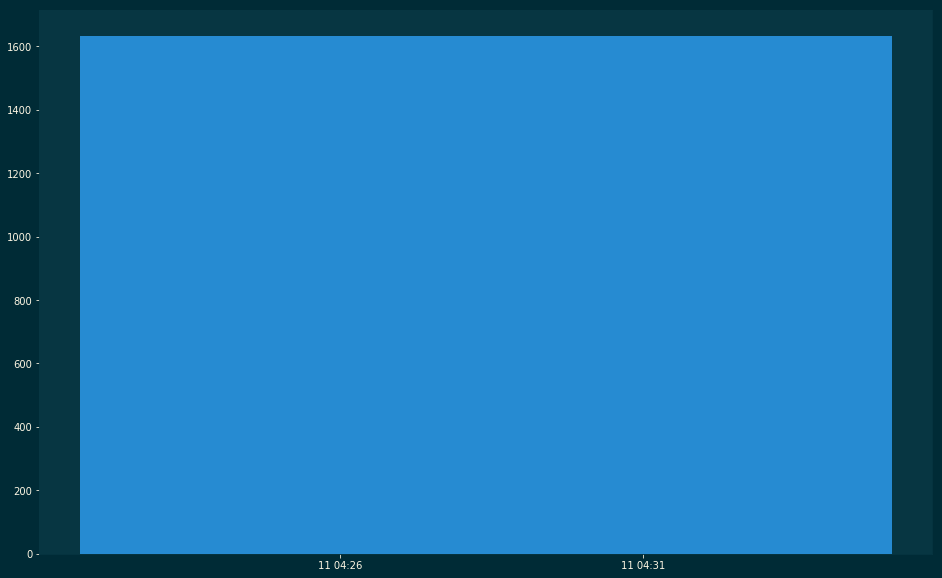

In [548]:
_ = creation_times.hist(bins = 1)

In [554]:
len(recent_hits)

1632

In [316]:
results = get_assignments(amt_con.connection, tqdm(recent_hits))

100%|██████████| 2201/2201 [04:20<00:00,  9.20it/s]


In [277]:
len(results)

5

In [278]:
results.values()

[[], [], [], [<boto.mturk.connection.Assignment at 0x11f16f9d0>], []]

In [312]:
len(results)

2201

In [279]:
tr = list(results.values())[3][0]

In [317]:
pickle_this(results, 'full_batch_2_update.pkl')

In [295]:
# pickle_this(results, 'test4b_2.pkl')

In [552]:
batch_8 = unpickle_this('./pickeled_results/turker_batch_8.pkl')

In [553]:
len(batch_8)

1632

# all hit cleanup

In [8]:
all_thus_far = unpickle_this('latest_result_all_8_31.pkl')

In [34]:
all_hits = unpickle_this('stage_3_full_hits_8_31.pkl')

In [41]:
all_hits[0]

In [35]:
len(all_hits)

64326

In [9]:
len(all_thus_far)

64326

In [11]:
all_asgmts = [item for sublist in all_thus_far for item in sublist]

In [12]:
len(all_asgmts)

192045

In [13]:
ta1 = all_asgmts[0]

In [17]:
statuses = pd.Series([asgmt.AssignmentStatus for asgmt in all_asgmts])

In [ ]:
statuses = pd.Series([asgmt.AssignmentStatus for asgmt in all_asgmts])

In [42]:
pd.Series([len(hit) for hit in all_hits]).value_counts()

1    64326
dtype: int64

In [18]:
statuses.value_counts()

Approved     188099
Rejected       2173
Submitted      1773
dtype: int64

In [19]:
pending_asgmts = [asgmt for asgmt in all_asgmts if asgmt.AssignmentStatus == 'Submitted']

In [20]:
len(pending_asgmts)

1773

In [21]:
ta1.AcceptTime

u'2017-07-13T06:54:11Z'

In [26]:
accept_times = pd.Series([dt_parse.parse(asgmt.AcceptTime) for asgmt in pending_asgmts])

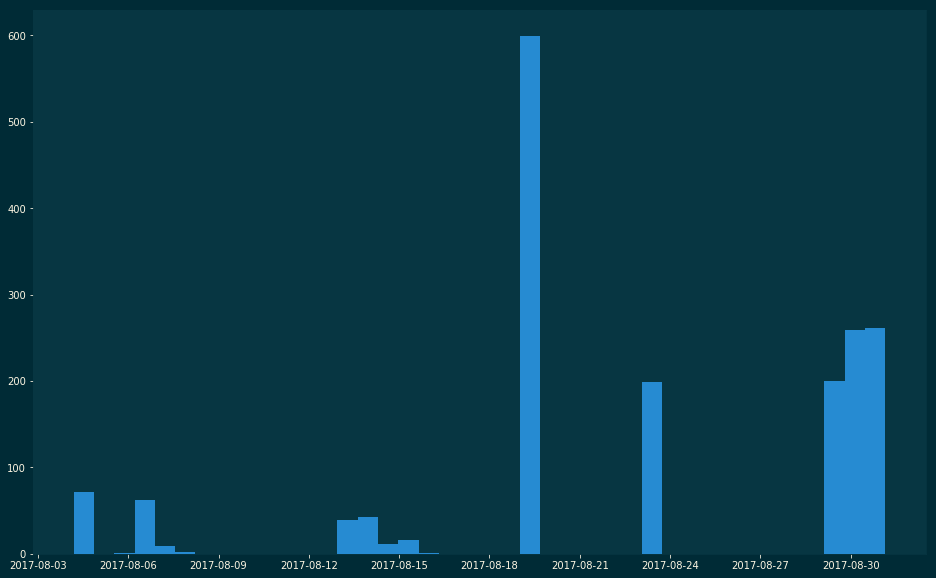

In [28]:
_ = accept_times.hist(bins = 40)

## check results

In [506]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [513]:
assignments =[]
for assignment_triple in list(results.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [514]:
characters_present

[{'characters': {u'judge'},
  'h_id': u'31S7M7DAGHQCUSQF0AU15OEW4LOLTV',
  'still_id': u's_06_e_04_shot_014628_014702_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'hoppy'},
  'h_id': u'3FI30CQHVLJUFLTRDKXEGBQD8LQ6BD',
  'still_id': u's_05_e_22_shot_037596_037670_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'wilma'},
  'h_id': u'35XW21VSVHEBFSD0BAPBVJIA22ALS6',
  'still_id': u's_02_e_29_shot_005091_005165_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'fred', u'wilma'},
  'h_id': u'3W3RSPVVGTRRU5540FKBAK0YNZVLUM',
  'still_id': u's_04_e_16_shot_018813_018887_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'barney', u'door', u'fred'},
  'h_id': u'3HUR21WDDVP3B86YOZKOOZ1YQY6YXD',
  'still_id': u's_01_e_24_shot_033229_033303_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'hat'},
  'h_id': u'3SMIWMMK62575ZH34TRDJVHEL8PUWI',
  'still_id': u's_02_e_08_shot_019539_019613_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'barney', u'roof'},


# Interact with workers

## reject assignments and ban workers

In [37]:
def ban_bad_workers(mturk_connection, worker_ids):
    for worker in worker_ids:
        reason_for_block = """
        Your HITs contained many frames with characters, but they were marked 'empty frame'
        """
        print('blocking ' + str(worker))
        mturk_connection.block_worker(worker, reason_for_block)

In [38]:
workers_to_ban = unpickle_this('workers_to_ban_prod_1_4.pkl')

In [39]:
workers_to_ban

{u'A13ISH3PAGHO0A',
 u'A15DOG6AXQ7LGY',
 u'A1CF1W8CP0DHB0',
 u'A1IOMFFEKCWOIT',
 u'A1QP6651C4Q8NS',
 u'A1RULXRXR2XF6M',
 u'A273GB71FE8RIV',
 u'A2CXEAMWU2SFV3',
 u'A2L97S8Z5FZK5N',
 u'A2NJTYYY37DNO',
 u'A2PU4YNWITAQVL',
 u'A2X7BE2FSPUKCK',
 u'A3R6KO03P9QLNO',
 u'A3UPV16IECELHV',
 u'A9ALF1SODWQE5'}

In [40]:
ban_bad_workers(amt_con.connection, list(workers_to_ban))

blocking A2PU4YNWITAQVL
blocking A273GB71FE8RIV
blocking A3R6KO03P9QLNO
blocking A2X7BE2FSPUKCK
blocking A1QP6651C4Q8NS
blocking A2CXEAMWU2SFV3
blocking A2NJTYYY37DNO
blocking A1CF1W8CP0DHB0
blocking A3UPV16IECELHV
blocking A2L97S8Z5FZK5N
blocking A1IOMFFEKCWOIT
blocking A15DOG6AXQ7LGY
blocking A9ALF1SODWQE5
blocking A1RULXRXR2XF6M
blocking A13ISH3PAGHO0A


In [46]:
to_reject = unpickle_this('assignments_to_reject_prod_1_4.pkl')

In [48]:
len(to_reject) * 0.04

378.16

In [43]:
def reject_assignments(mturk_connection, assignments_to_reject):
    feedback_message = """
    Your HITs contained many frames with characters, but they were marked 'empty frame'
    """
    reject_count = len(assignments_to_reject)
    for assignment_id in tqdm(assignments_to_reject):
        try:
            mturk_connection.reject_assignment(assignment_id, feedback_message)
        except boto.mturk.connection.MTurkRequestError:
            print('assignment ' + str(assignment_id) + ' already accepted or rejected')

    return reject_count

In [45]:
# reject_assignments(amt_con.connection, list(to_reject))

## pay bonuses

In [ ]:
subject = "More  HITs are available"
message = """
Hello, 

"""

In [ ]:
# _ = mturk.notify_workers(good_workers[:20], subject, message)

In [455]:
bonuses = unpickle_this('bonuses_to_pay_3.pkl')

In [458]:
def pay_bonuses(bonuses_to_pay):
    total_payed = 0
    bonus_reason_template = 'For Flinstones character labels written.'
    for aid, vals in tqdm(bonuses_to_pay.items()):
        n_chars = vals['count']
        wid = vals['worker_id']
        bonus_ammount = boto.mturk.price.Price(0.01 * n_chars)
        total_payed += bonus_ammount.amount
        bonus_reason = bonus_reason_template
        amt_con.connection.grant_bonus(wid, aid, bonus_ammount, bonus_reason)
    return total_payed

In [460]:
# pay_bonuses(bonuses)

# Accepting and deleting HITs

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [8]:
accept_results = unpickle_this('pickeled_results/prod_batch_1_4.pkl')

In [9]:
len(accept_results)

20000

In [80]:
assignments =[]
for assignment_triple in list(first_prod_batch.values()):
    assignments.extend(assignment_triple)

len(assignments)

25067

In [82]:
latest_assignments =[]
for assignment_triple in list(first_prod_batch.values()):
    latest_assignments.extend(assignment_triple)

len(latest_assignments)

ta1 = latest_assignments[0]

assignments_statuses = [asgmt.AssignmentStatus for asgmt in latest_assignments]

In [84]:
pd.Series(assignments_statuses).value_counts()

Submitted    25067
dtype: int64

In [35]:
to_reject = unpickle_this('./assignments_to_reject_prod_1_4.pkl')

In [36]:
len(to_reject)

9454

In [12]:
assignments_to_accept = [asgmt for asgmt in assignments if asgmt.AssignmentId not in to_reject]

In [13]:
len(assignments_to_accept)

59836

In [85]:
e_count = 0
for assignment in tqdm(latest_assignments):
    try:
        amt_con.approve_assignment(assignment)
    except boto.mturk.connection.MTurkRequestError as e:
        e_count += 1

100%|██████████| 25067/25067 [1:18:49<00:00,  4.68it/s]


In [33]:
e_count

0

In [ ]:
print(e_count)

In [ ]:
# _ = [amt_con.disable_hit(hit) for hit in hits_today]

In [ ]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [187]:
amt_con.get_account_balance()

$10,000.00

In [273]:
amt_con.delete_all_hits()

In [178]:
# _ = [amt_con.disable_hit(hit) for hit in tqdm(all_hits)]

In [43]:
e_count = 0
for hitid in tqdm(all_hits):
    try:
        amt_con.disable_hit(hitid[0])
    except boto.mturk.connection.MTurkRequestError as e:
        e_count += 1

100%|██████████| 64326/64326 [2:07:16<00:00,  6.91it/s]  
